In [772]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

def blur_image(image, blur_kernel_size):
    if len(image.shape) > 2 and image.shape[2] > 1:
        # If image has more than one channel, convert it to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        # If image is already grayscale, no need for conversion
        grayscale_image = image
    else:
        raise ValueError("Unsupported image format")

    # Apply blur filter
    blurred_image = cv2.GaussianBlur(grayscale_image, (blur_kernel_size, blur_kernel_size), 0)
    
    return blurred_image


def filtrar_color_amarillo(imagen):
    # Convertir la imagen a formato HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Definir el rango de colores amarillos en HSV
    lower_yellow = np.array([18, 100, 100])
    upper_yellow = np.array([26, 255, 255])
    
    # Aplicar el filtro para detectar solo el color amarillo
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Crear una imagen binaria utilizando la máscara
    resultado = cv2.bitwise_and(imagen, imagen, mask=mask)
    
    return mask, resultado

def remove_small_particles(binary_image, min_area):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask to store the filtered particles
    filtered_mask = np.zeros_like(binary_image)
    
    # Iterate through contours
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)
        
        # If the area is larger than the minimum area threshold, keep the contour
        if area >= min_area:
            cv2.drawContours(filtered_mask, [contour], -1, 255, cv2.FILLED)
    
    return filtered_mask





def remove_small_particles2(binary_image, min_area):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create lists to store positions and areas of particles
    particle_positions = []
    particle_areas = []
    
    # Create a mask to store the filtered particles
    filtered_mask = np.zeros_like(binary_image)
    
    # Iterate through contours
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)
        
        # If the area is larger than the minimum area threshold, keep the contour
        if area >= min_area:
            # Get the centroid of the contour
            M = cv2.moments(contour)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            
            # Append position and area to the lists
            particle_positions.append([cx, cy])
            particle_areas.append(area)
            
            # Draw the contour on the filtered mask
            cv2.drawContours(filtered_mask, [contour], -1, 255, cv2.FILLED)
    
    # Convert lists to NumPy arrays
    particle_positions = np.array(particle_positions)
    particle_areas = np.array(particle_areas)
    
    return filtered_mask, particle_positions, particle_areas

def expand_binary_zone(binary_image, iterations=1):
    # Definir el kernel para la operación de dilatación
    kernel = np.ones((3, 3), np.uint8)
    
    # Aplicar la operación de dilatación
    expanded_image = cv2.dilate(binary_image, kernel, iterations=iterations)
    
    return expanded_image



def shrink_binary_zone(binary_image, iterations=1):
    # Define the kernel for the erosion operation
    kernel = np.ones((3, 3), np.uint8)
    
    # Apply the erosion operation
    shrunk_image = cv2.erode(binary_image, kernel, iterations=iterations)
    
    return shrunk_image

def filtering_1(imagen, mode=0,dif=3,bordes=1):

    mask_amarillo, resultado_amarillo = filtrar_color_amarillo(imagen)
    # Mostrar las imágenes

    # Set the minimum area threshold
    height, width = mask_amarillo.shape
    min_area_threshold = int(height*width*0.005)

    # Remove small particles from the binary image
    filtered_image,areas,positions = remove_small_particles2(mask_amarillo, min_area_threshold)

    if mode!=0:
        cv2.imshow('Original', imagen)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Máscara Amarilla', mask_amarillo)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    filtered_image=expand_binary_zone(filtered_image,dif)

    if mode!=0:
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    filtered_image=shrink_binary_zone(filtered_image,dif)

    if mode!=0:
        cv2.imshow('Filtered Binary Image', filtered_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    if (bordes==1):
        bordes = cv2.Canny(filtered_image, 100, 200)
    else:
        bordes = filtered_image
    if mode!=0:
        cv2.imshow('Bordes', bordes)
        cv2.waitKey(0)
        #cv2.waitKey(0)
        cv2.destroyAllWindows()
    return bordes , filtered_image

def centroid_and_area(binary_image):
    # Encuentra los contornos en la imagen binaria
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centroids = []
    areas = []
    
    # Itera sobre los contornos encontrados
    for contour in contours:
        # Calcula el centroide del contorno
        M = cv2.moments(contour)
        if M['m00'] != 0:  # Asegura que no hay división por cero
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
        
        # Calcula el área del contorno
        area = cv2.contourArea(contour)
        areas.append(area)
    
    return centroids, areas




In [773]:
import cv2
import numpy as np
import math
def add_border(image, top, bottom, left, right):
    """
    Add borders of specified size to a binary image.

    Parameters:
        image: Input binary image.
        top: Size of the top border.
        bottom: Size of the bottom border.
        left: Size of the left border.
        right: Size of the right border.

    Returns:
        Image with borders added.
    """
    # Define border size for each side
    border_size = (top, bottom, left, right)

    # Create a border filled with zeros
    bordered_image = np.zeros((image.shape[0] + top + bottom, image.shape[1] + left + right), dtype=np.uint8)

    # Copy the original image to the center of the bordered image
    bordered_image[top:top + image.shape[0], left:left + image.shape[1]] = image

    return bordered_image



def linear_transform(image, transformation_matrix, output_size):
    transformed_image = cv2.warpAffine(image, transformation_matrix, output_size, flags=cv2.INTER_NEAREST)
    return transformed_image

def ScalRot_transformation(image,scale_x,scale_y,angle_a_deg,vertical_shift,horizontal_shift):
    angle_a_rad = math.radians(angle_a_deg)

    # Calculate the transformation matrix
    transformation_matrix = np.float32([
        [scale_x * math.cos(angle_a_rad)  +horizontal_shift*scale_x * math.sin(angle_a_rad)    ,   horizontal_shift*scale_y * math.cos(angle_a_rad)   -scale_y * math.sin(angle_a_rad), 30],
        [scale_x * math.sin(angle_a_rad)  +vertical_shift*scale_x * math.cos(angle_a_rad)      ,  -vertical_shift*scale_y * math.sin(angle_a_rad)   +scale_y * math.cos(angle_a_rad), 0 ]
    ])
    # Get the shape of the input image
    height, width = image.shape[:2]
    # Calculate the size of the output image to accommodate all pixels
    corners = np.array([[0, 0], [width, 0], [0, height], [width, height]])
    transformed_corners = cv2.transform(np.array([corners]), transformation_matrix)[0]
    min_x, min_y = np.min(transformed_corners, axis=0)
    max_x, max_y = np.max(transformed_corners, axis=0)
    output_size = (int(max_x - min_x), int(max_y - min_y))
    # Update the transformation matrix to translate the image to keep it within bounds
    transformation_matrix[0, 2] -= min_x
    transformation_matrix[1, 2] -= min_y
    # Apply the affine transformation
    transformed_image = linear_transform(image, transformation_matrix, output_size)

    return transformed_image

def Calculate_pixel_position(px, py, height, width, scale_x, scale_y, angle_a_deg,vertical_shift,horizontal_shift):
    angle_a_rad = math.radians(angle_a_deg)

    # Calculate the transformation matrix
    transformation_matrix = np.float32([
        [scale_x * math.cos(angle_a_rad)  +horizontal_shift*scale_x * math.sin(angle_a_rad)    ,   horizontal_shift*scale_y * math.cos(angle_a_rad)   -scale_y * math.sin(angle_a_rad), 30],
        [scale_x * math.sin(angle_a_rad)  +vertical_shift*scale_x * math.cos(angle_a_rad)      ,  -vertical_shift*scale_y * math.sin(angle_a_rad)   +scale_y * math.cos(angle_a_rad), 0 ]
    ])
    # Get the shape of the input image
    # Calculate the size of the output image to accommodate all pixels
    corners = np.array([[0, 0], [width, 0], [0, height], [width, height]])
    transformed_corners = cv2.transform(np.array([corners]), transformation_matrix)[0]
    min_x, min_y = np.min(transformed_corners, axis=0)
    max_x, max_y = np.max(transformed_corners, axis=0)
    # Apply the affine transformation
    transformed_point = cv2.transform(np.array([[[px, py]]]), transformation_matrix)[0][0]
    # Translate the image to keep it within bounds
    transformed_point[0] -= min_x
    transformed_point[1] -= min_y
    return transformed_point

In [774]:
import random
def Obj_fun(atributes,BinImage=0,BinKernel=0,mode=0):
    if (type(BinImage)==int or type(BinKernel)==int):
        print('there are no minaes')
        return 0
    [a,px,py,Ax,Ay,my,mx]=atributes
    if mode!=0:
        cv2.imshow('ker Binary Image', BinKernel)
        cv2.imshow('img Binary Image', BinImage)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    new_img=ScalRot_transformation(BinImage,Ax,Ay,a,my,mx)
    height, width = BinKernel.shape

    if mode!=0:
        cv2.imshow('ker Binary Image', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    new_img=add_border(new_img,int(height),int(height),int(width),int(width))
    H,W=BinImage.shape
    [px,py]=Calculate_pixel_position(px,py,H,W,Ax,Ay,a,my,mx)
    px=int(px)+width
    py=int(py)+height 
    if mode!=0:
        cv2.imshow('img Binary Image', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    new_img = new_img[py:py+height, px:px+width]
    #print(new_img.shape)
    #print(M)
    #print(py+height,px+width)
    new_img = cv2.resize(new_img, (width, height), interpolation=cv2.INTER_NEAREST)

    if mode!=0:
        cv2.imshow('img Binary Image', new_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    result = cv2.bitwise_and(new_img, new_img, mask=BinKernel)
    if mode!=0:
        cv2.imshow('diff Binary Image', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return (np.sum(result))/(20*height*width)
    
def rep_fun(atributes1,atributes2):
        return (atributes1 + atributes2)/2

def mut_fun(atributes,ImgH=0,ImgW=0,KerH=0,KerW=0,no_amp=0):
    [a,px,py,Ax,Ay,my,mx]=atributes
    if (no_amp==0):
        amp = (random.random()*0.2 + 0.9)
        Ax=amp*Ax
        amp = (random.random()*0.2 + 0.9)
        Ay=amp*Ay
    step=random.randint(0, int(ImgW/25))-int(ImgW/50)
    px+=step
    step=random.randint(0, int(ImgH/25))-int(ImgH/50)
    py+=step
    step=random.random()*4 - 2
    a+=step

    step=random.random()*0.2 -0.1
    mx+=step

    if abs(mx)>0.5:
        mx-=step
    step=random.random()*0.2 -0.1
    my+=step

    if abs(my)>0.5:
        my-=step

    if Ax<0.001:
        Ax=0.0015
    elif Ax>(1)*(2):
        Ax=(1)*(2)
    if Ay<0.001:
        Ay=0.0015
    elif Ay>(1)*(2):
        Ay=(1)*(2)
    if px > ImgW:
        px=ImgW
    elif px < 0:
        px=0
    if py > ImgH:
        py=ImgH
    elif py < 0:
        py=0
    if a >35:
        a=35
    elif a <-35:
        a=-35
    
    return [a,px,py,Ax,Ay,my,mx]


def MakeaRandSeed(n,ImgH=0,ImgW=0,KerH=0,KerW=0):
    seed=np.zeros((n, 7))
    for i in range(0,n):
        Ax = random.random()*(1) + (1)*0.5

        Ay = random.random()*(1) + (1)*0.5

        px=random.randint(0, ImgW)

        py=random.randint(0, ImgH)

        a=random.random()*5 -2.5

        mx=random.random()*0.5 -0.25
        my=random.random()*0.5 -0.25
        seed[i][:]=[a,px,py,Ax,Ay,my,mx]


        

    return seed
    

In [775]:
import random
class GenAlg:
    def __init__(GA, Npop, Nvar,Ofun,Rfun,Mfun):
        GA.Npop=Npop
        GA.Nvar=Nvar

        GA.population = np.zeros((Npop, Nvar))
        GA.fitness=np.zeros(Npop)


        GA.ObjFun=Ofun
        GA.RepFun=Rfun
        GA.MutpFun=Mfun

        GA.temp=1
        GA.best=np.zeros(Nvar)
        GA.bestVal=-1000000000

        GA.Pmut=1
        GA.Prep=0.1


    def FitEval(GA):
        for i in range(0,GA.Npop):
            GA.fitness[i]=GA.ObjFun(GA.population[i])
            if GA.fitness[i]>GA.bestVal:
                GA.best=np.array(GA.population[i])
                GA.bestVal=GA.fitness[i]



    def EstReprod(GA):
        GA.FitEval()
        # Apply temperature scaling to the logits
        GA.fitness = GA.fitness / GA.temp

        # Compute softmax probabilities
        exp_logits = np.exp(GA.fitness)
        GA.fitness = (exp_logits / np.sum(exp_logits))*GA.Npop

    def New_pop(GA):
        GA.EstReprod()
        old_Pop = GA.population
        i=0
        n=0
        for i in range(0,GA.Npop):
            while(GA.fitness[i]>=1):
                GA.fitness[i]=GA.fitness[i]-1
                GA.population[n]=old_Pop[i]
                n=n+1


        N = GA.Npop-n
        indices_n_mayores = np.argsort(GA.fitness)[-N:]
        for i in range(0,N):
            GA.population[n]=old_Pop[indices_n_mayores[i]]
            n=n+1

        
        old_Pop = GA.population
        for i in range(0,GA.Npop):
            mate=random.randint(0, GA.Npop)-1
            ran = random.random()
            if ran<GA.Prep:
                GA.population[i]=GA.RepFun(GA.population[i],old_Pop[mate])
            ran = random.random()
            if ran<GA.Pmut:
                GA.population[i]=GA.MutpFun(GA.population[i]) 


    def emulate_Ngen(GA,n):
        for i in range(0,n):
            #print(i/n*100,'%')
            GA.New_pop()





    def setSeed(GA,seed):
        GA.population=seed

    def put_best(GA):
        GA.population[random.randint(0, GA.Npop)-1]=GA.best
        
    def put_a_Seed(GA,seed):
        GA.population[random.randint(0, GA.Npop)-1]=seed

    def setRepFun(GA,rep):
        GA.RepFun=rep

    def setObjFun(GA,obj):
        GA.ObjFun=obj

    def setMutFun(GA,mut):
        GA.MutpFun=mut

    def setTemp(GA,t):
        GA.temp=t
    
    def setPmut(GA,t):
        GA.Pmut=t

    def setPrep(GA,t):
        GA.Prep=t
    
    def reset_bestval(GA):
        GA.bestVal=-1000000000

        






            
    

In [776]:
def test(kernName,imgName):

    #extraccion del kernel
    kernel_name = kernName
    kernel = cv2.imread(kernel_name)
    bord_kernel,filt=filtering_1(kernel, dif=2)
    full_kernel,filt=filtering_1(kernel, dif=2,bordes=0)

    #extraccion de la imagen
    img_name = imgName
    img = cv2.imread(img_name)
    img = cv2.resize(img, (500, int((500/img.shape[1])*img.shape[0])), interpolation=cv2.INTER_NEAREST)
    bord_img,filt=filtering_1(img)
    full_img,filt=filtering_1(img,bordes=0)

    #parametros para la red
    population_size=25
    kh, kw = bord_kernel.shape
    ih, iw = bord_img.shape
    seed=MakeaRandSeed(100,ImgH=ih,ImgW=iw,KerH=kh,KerW=kw)

    #suavizacion de la imagen
    bord_img=expand_binary_zone(bord_img,1)
    bord_kernel=expand_binary_zone(bord_kernel,1)
    bord_img=blur_image(bord_img,7)

    #declaracion de la red 
    population=GenAlg(population_size,6, lambda x:  Obj_fun(x,BinImage=bord_img,BinKernel=bord_kernel,mode=0),rep_fun, lambda x: mut_fun(x,ImgH=ih,ImgW=iw,KerH=kh,KerW=kw))
    population.setSeed(seed)



    T=10
    population.setObjFun(lambda x: Obj_fun(x,BinImage=bord_img,BinKernel=bord_kernel,mode=0))
    population.setPrep(0.1)
    population.reset_bestval()
    while (T>0.01):
        population.setTemp(T)
        population.emulate_Ngen(5) 
        population.put_best() 
        T*=0.8
    seed=population.best


    for i in range(0,5):
        T=0.05
        population.setObjFun(lambda x: Obj_fun(x,BinImage=full_img,BinKernel=full_kernel,mode=0))
        population.setMutFun(lambda x: mut_fun(x,ImgH=ih,ImgW=iw,KerH=kh,KerW=kw,no_amp=1))
        population.setPrep(0.8)
        population.reset_bestval()
        population.setTemp(T)
        population.emulate_Ngen(20) 
        population.put_a_Seed(seed)


        T=0.1
        population.setObjFun(lambda x: Obj_fun(x,BinImage=bord_img,BinKernel=bord_kernel,mode=0))
        population.setMutFun(lambda x: mut_fun(x,ImgH=ih,ImgW=iw,KerH=kh,KerW=kw))
        population.setPrep(0.1)
        population.reset_bestval()
        while (T>0.01):
            population.setTemp(T)
            population.emulate_Ngen(6) 
            population.put_best() 
            T*=0.8
        seed=population.best

    # Suponiendo que `img` y `kernel` son las imágenes que mencionaste


    [a,px,py,Ax,Ay,my,mx]=population.best
    print(population.best)
    [px,py]=Calculate_pixel_position(px,py,ih,iw,Ax,Ay,a,my,mx)
    px=int(px)
    py=int(py)
    img2=ScalRot_transformation(img,Ax,Ay,a,my,mx)
    new_img = img2[py:py+kh, px:px+kw]
    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')

    # Mostrar la imagen recortada
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Recortada')

    plt.show()
        

1
[-6.28690790e+00  4.13218750e+02  3.55781250e+01  1.71459371e+00
  1.41506118e+00 -4.87725369e-03 -3.17916857e-01]


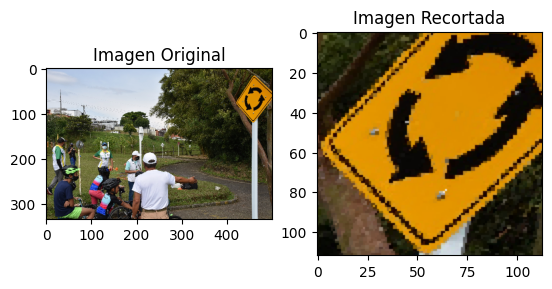

2
[-3.24848365e+00  1.23147753e+02  8.79880683e+01  9.04912483e-01
  1.09405819e+00  2.70347616e-02  7.09059398e-02]


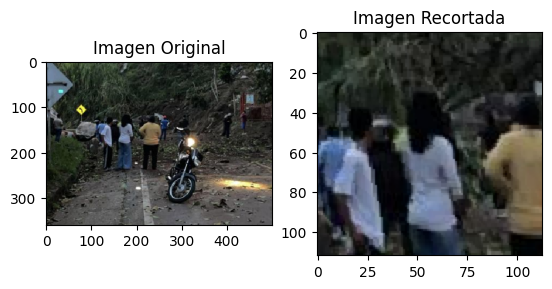

3
[-6.52149411e+00  2.25504883e+02  2.61941406e+02  1.23791681e+00
  6.45354721e-01  2.73402684e-01 -1.19463028e-01]


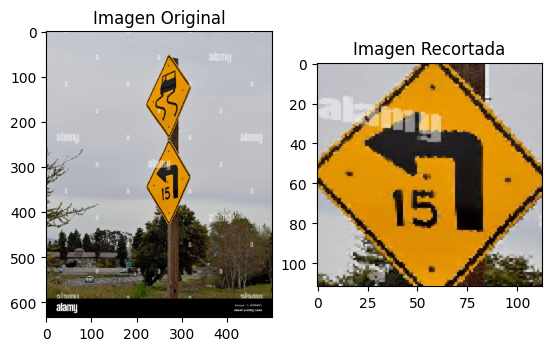

4
[-1.07667406e+01  2.42957599e+02  3.33795822e+01  9.85079175e-01
  9.25968086e-01  2.01618053e-01 -2.28474213e-01]


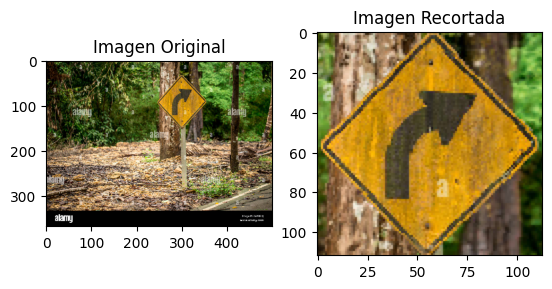

5
[15.88086695 29.76123047 49.32958984  0.92606085  0.56873418 -0.17581651
  0.24708109]


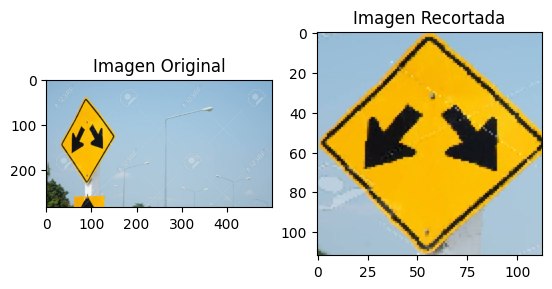

6
[ -1.91015045 172.65545654 238.40338135   1.03247581   1.49474438
   0.4412475   -0.49872194]


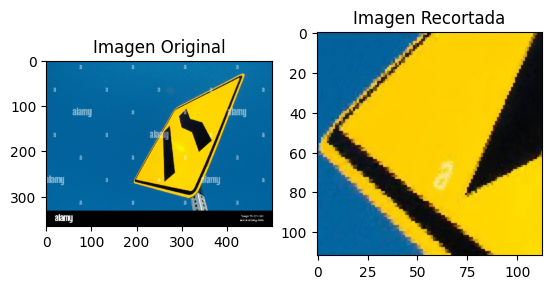

7
[ 4.89120455e+00  1.86538330e+02  1.91489258e+02  1.19731905e+00
  1.05057030e+00 -8.21943754e-03 -8.01408897e-02]


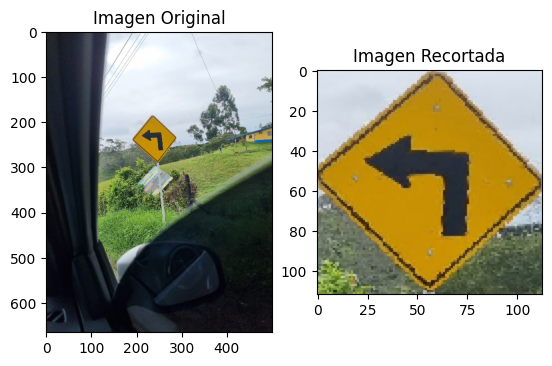

8
[-9.52641609e+00  3.03070312e+02  1.77156250e+02  1.08780599e+00
  1.03142583e+00  1.29068421e-01 -2.82237139e-01]


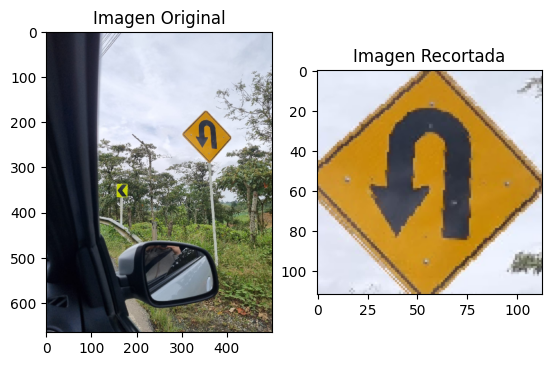

9
[ 6.69331042e+00  3.33824075e+02  4.05917290e+02  1.31091451e+00
  9.65680514e-01  2.11242467e-03 -1.32065373e-01]


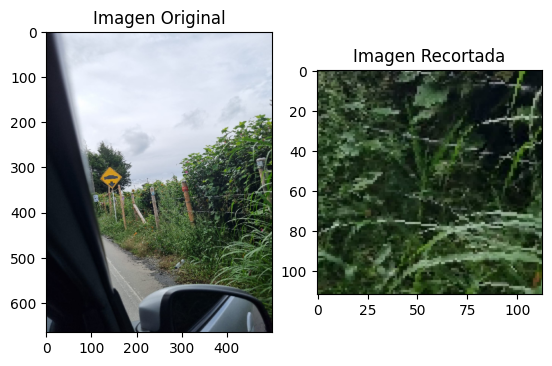

10
[-1.89706766e+00  2.01574219e+02  2.12281250e+02  1.30981113e+00
  1.16854026e+00  7.61908166e-02 -2.50319962e-01]


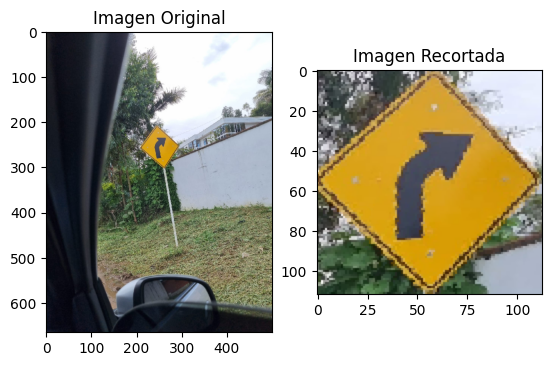

11
[ 9.15666230e+00  3.04196419e+02  1.71108604e+02  1.01537509e+00
  8.86606570e-01 -2.89104546e-01  5.11998962e-02]


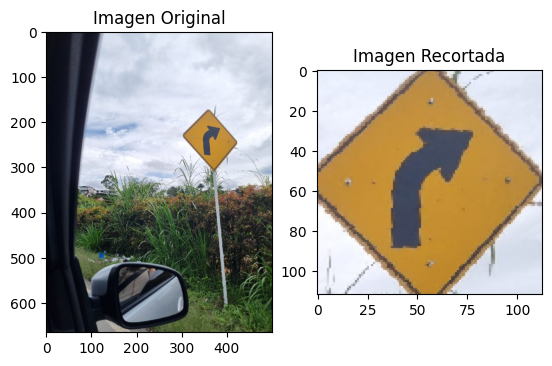

12
[-6.79140743e+00  2.20437500e+02  1.73614258e+02  9.34684831e-01
  7.57523291e-01  8.05089780e-02 -4.22013008e-02]


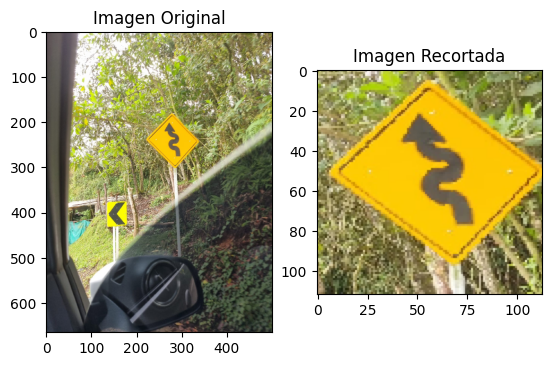

In [777]:
for i in range(1, 13):
    print(i)
    image2 = f"test{i}.jpg"
    image1 = "Rombo.jpg"  # Suponiendo que este es el nombre de la imagen fija
    
    test(image1, image2)
